In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM, MaxPooling1D, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape
import keras
from keras.layers import AveragePooling1D

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
%%time 

train_df = pickle.load( open("cache/train_df_256_aug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df_256.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_256.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_256_aug.pik","rb"))


CPU times: user 14.2 s, sys: 28.1 s, total: 42.4 s
Wall time: 3min 41s


In [48]:
test_df =  pickle.load(open("cache/test_df_256.pik","rb"))

In [4]:
train_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)
unknown_df.reset_index(inplace=True,drop=True)
silent_df.reset_index(inplace=True,drop=True)

In [5]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*2)],axis=0 )
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [30]:
# %time t = next(train_generator(256))[0][0].T

In [6]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [49]:
test_preds = np.load("cache/predictions_conv2dlstm_plus_longblend1.npy")

In [50]:
test_preds[np.where(test_preds.max(axis=1)<0.5)[0]] = to_categorical(name2id["unknown"],num_classes = len(POSSIBLE_LABELS))[0]

test_preds = to_categorical(np.argmax(test_preds, axis=1),num_classes = len(POSSIBLE_LABELS))


In [51]:
def test_pseudo_generator(test_batch_size):
    this_test = test_df #.sample(int(train_df.shape[0]//5* 0.1))
    this_test["id"] = this_test.index.values
    
#     this_test.reset_index(inplace=True)
    while True:

        shuffled_ids = random.sample(range(test_df.shape[0]), test_df.shape[0])

        for start in range(0, len(test_df), test_batch_size):
            x_batch = []
            y_batch = []

            end = min(start + test_batch_size, len(shuffled_ids))
            i_test_batch = shuffled_ids[start:end]

            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
    #                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(test_preds[test_df.loc[i,'id']])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch)

            yield x_batch, y_batch

In [52]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list

        self.N = 64 

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):

        nexts = [next(it) for it in self.iters]
#         print nexts[0][0].shape, nexts[1][0].shape
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [53]:
mi = MixIterator([train_generator(50), test_pseudo_generator(14)])


In [31]:
valid_df.label_id.value_counts()

11    4221
1      270
3      264
0      261
2      260
9      260
10     257
6      257
7      256
5      256
4      247
8      246
Name: label_id, dtype: int64

In [67]:
%time t = next(valid_generator(64))

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.89 ms


In [68]:
valid_df.loc[0,'raw'].shape

(256, 32)

In [69]:
t[0].shape

(64, 32, 256)

In [7]:
#a common practice is to choose a filter size in time which spans 2/3 o

### Model

In [7]:
p = 0.


In [8]:
def batch_relu(x):
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    return x 

In [22]:
p =0.
def get_1dconvs_maxpool_freq_deep( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    
    x = Conv1D(64,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(64,filter_size,activation='relu',padding='same')(x)
    
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x  = MaxPooling1D(2)(x)   

    
    x = Conv1D(128,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(128,filter_size,activation='relu',padding='same')(x)

    x = Dropout(p/2)(x)
    
    
    x = BatchNormalization()(x)
    x  = MaxPooling1D(2)(x)   

    x = Conv1D(256,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(256,filter_size,activation='relu',padding='same')(x)

    x = Dropout(p/2)(x)    
    
    
    x = BatchNormalization()(x)
    x  = MaxPooling1D(2)(x) 
    

    x = Conv1D(512,filter_size,activation='relu',padding='same')(x)
    x = Conv1D(512,filter_size,activation='relu',padding='same')(x)

    x = Dropout(p/2)(x)    
    
    
    x = BatchNormalization()(x)
    x  = AveragePooling1D(2)(x) 
    
    
    
    x_max = GlobalMaxPooling1D()(x)
#     x_avg = GlobalAveragePooling1D()(x)

#     x = concatenate([x_max,x_avg])
    
    return x_max

In [178]:
def dilated_timeconvs( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    
    x = Conv1D(64,filter_size,activation='relu',padding='same',dilation_rate=2)(x)
    x = Conv1D(64,filter_size,activation='relu',padding='same',dilation_rate=2)(x)
    x = Conv1D(64,filter_size,activation='relu',padding='same',dilation_rate=2)(x)
    
    x = Dropout(p/2)(x)
    x = BatchNormalization()(x)

#     x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(128,filter_size,activation='relu')(x)
    x = Conv1D(128,filter_size,activation='relu')(x)
    x = Conv1D(128,filter_size,activation='relu')(x)
    
    x = Dropout(p/2)(x)
    x = BatchNormalization()(x)



#     x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(128,filter_size,activation='relu')(x)
    x = Conv1D(128,filter_size,activation='relu')(x)
    x = Conv1D(128,filter_size,activation='relu')(x)

    x = Dropout(p/2)(x)

    x = AveragePooling1D()(x)
    x = BatchNormalization()(x)


    x_max = GlobalMaxPooling1D()(x)

    
    return x_max

In [9]:
def get_conv_stacks( x_in, filter_size=5):
    x = BatchNormalization()(x_in)
    
    x = Conv1D(32,filter_size,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(64,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
       
    x = MaxPooling1D()(x)
    
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)    
        

#     x = Conv1D(256,3,padding='same')(x)
#     x = batch_relu(x)
#     x = Conv1D(256,3,padding='same')(x)
#     x = batch_relu(x)  
    
    x = Bidirectional(CuDNNLSTM(128,return_sequences=False))(x)
    
#     x = AveragePooling1D()(x)
#     x = GlobalMaxPooling1D()(x)


    
    return x

In [17]:
p = 0.0


def get_freqconv_lstm( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    
    
    x = Conv1D(64,filter_size,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(64,filter_size,padding='same')(x)
    x = batch_relu(x)
    
    
    x = Dropout(p/2)(x)
    x  = MaxPooling1D(2)(x)   



    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)

    x = Dropout(p/2)(x)    
    x  = MaxPooling1D(2)(x) 
    

    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)

    x  = MaxPooling1D(2)(x) 
    

    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Bidirectional(CuDNNLSTM(128,return_sequences=False))(x)

    return x

In [29]:
p = 0.0


def get_1dconvs_maxpool_freq_deep_fixed( x_in, kernel_size=10):
    
    x = BatchNormalization()(x_in)
    
    
    x = Conv1D(64,kernel_size,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(64,kernel_size,padding='same')(x)
    x = batch_relu(x)
    
    
    x = Dropout(p/2)(x)
    x  = MaxPooling1D(2)(x)   



    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)

    x = Dropout(p/2)(x)    
    x  = MaxPooling1D(2)(x) 
    

    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Dropout(p/2)(x)    
    x  = MaxPooling1D(2)(x) 
    
    
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Dropout(p/2)(x)     
    x  = AveragePooling1D(2)(x) 
    
    
    
    x_max = GlobalMaxPooling1D()(x)
#     x_avg = GlobalAveragePooling1D()(x)

#     x = concatenate([x_max,x_avg])
    
    return x_max

In [30]:
from keras.layers import *

In [31]:
# p = 0.3

timesteps, input_dim , latent_dim = 32,256, 128

x_logml = Input(shape=(timesteps, input_dim)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]
x_freq = Reshape((input_dim, timesteps))(x_logml)


# x_3 = get_conv_stacks(x_logml,3)
# x_5 = get_conv_stacks(x_logml,5)
# x_1 = max_timeconvs(x_logml,2)

# x_time = concatenate([x_1,x_2,x_3])

# x_3 = get_1dconvs_maxpool_residuals(x_freq)




# 0.86
# xf_2= get_1dconvs_maxpool_freq_deep(x_freq,2)
xf_5 = get_1dconvs_maxpool_freq_deep_fixed(x_freq,10)
# xf_10 = get_1dconvs_maxpool_freq_deep_shortcut(x_freq,10)

# x_freq = concatenate([xf_2,xf_5,xf_10])


# xf_2= get_1dconvs_maxpool_freq_deep_shortcut (x_freq,2)
# xf_5 = get_1dconvs_maxpool_freq_deep_shortcut(x_freq,5)
# xf_10 = get_1dconvs_maxpool_freq_deep_shortcut(x_freq,10)

# x_freq = concatenate([xf_2,xf_5,xf_10])

# x = add([x_3,xf_5])
# x_3 = get_1dconvs_maxpool_residuals(x_freq)

x = Dense(128, activation = 'relu')(xf_5) #
x = Dropout(0.3)(x)


# x = Dense(200, activation = 'relu')(x) #
# x = Dropout(0.1)(x)


x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




In [32]:
from keras.optimizers import SGD

# optimizer = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#Adam(lr=1e-3)
model = Model(inputs = x_logml, outputs = x)
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
timesteps, input_dim , latent_dim = 32,256, 128


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 256)           0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 256, 32)           0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 256, 32)           128       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 256, 64)           20544     
_________________________________________________________________
batch_normalization_29 (Batc (None, 256, 64)           256       
_________________________________________________________________
activation_25 (Activation)   (None, 256, 64)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 256, 64)           41024     
__________


one conv, one lstm, 128
Epoch 00029: 
461/461 [==============================] - 9s 20ms/step - loss: 0.2684 - acc: 0.9172 - val_loss: 0.1769 - val_acc: 0.9465


Epoch 34/100, 256
461/461 [==============================] - 10s 22ms/step - loss: 0.2585 - acc: 0.9220 - val_loss: 0.1716 - val_acc: 0.9458

Epoch 28/100, 128 (3 convs, 16,8,4)
461/461 [==============================] - 12s 27ms/step - loss: 0.2704 - acc: 0.9181 - val_loss: 0.1600 - val_acc: 0.9476


above lstm 64
Epoch 33/100
461/461 [==============================] - 14s 31ms/step - loss: 0.2349 - acc: 0.9271 - val_loss: 0.1589 - val_acc: 0.9484
lstm 128
Epoch 23/100
461/461 [==============================] - 14s 30ms/step - loss: 0.2068 - acc: 0.9349 - val_loss: 0.1487 - val_acc: 0.9535
above, dense 64
Epoch 34/100
461/461 [==============================] - 14s 30ms/step - loss: 0.1626 - acc: 0.9467 - val_loss: 0.1455 - val_acc: 0.9552
double lstm
Epoch 39/100
461/461 [==============================] - 18s 38ms/step - loss: 0.1516 - acc: 0.9497 - val_loss: 0.1462 - val_acc: 0.9565

bilstm
Epoch 23/100
461/461 [==============================] - 19s 41ms/step - loss: 0.1740 - acc: 0.9435 - val_loss: 0.1382 - val_acc: 0.9584

extra layers
Epoch 27/100
461/461 [==============================] - 21s 45ms/step - loss: 0.1681 - acc: 0.9451 - val_loss: 0.1474 - val_acc: 0.9577

shrinking filters
Epoch 42/100
461/461 [==============================] - 22s 47ms/step - loss: 0.1486 - acc: 0.9499 - val_loss: 0.1383 - val_acc: 0.9575

convs between 2 lstms 
Epoch 20/100
461/461 [==============================] - 44s 96ms/step - loss: 0.2450 - acc: 0.9212 - val_loss: 0.1574 - val_acc: 0.9515





Epoch 25/100
461/461 [==============================] - 23s 50ms/step - loss: 0.1748 - acc: 0.9426 - val_loss: 0.1267 - val_acc: 0.9617
Epoch 25/100 double lstm
461/461 [==============================] - 38s 82ms/step - loss: 0.1680 - acc: 0.9459 - val_loss: 0.1415 - val_acc: 0.9599


freqconv_deep_buggy?
Epoch 2/100
461/461 [==============================] - 46s 100ms/step - loss: 0.1698 - acc: 0.9460 - val_loss: 0.1111 - val_acc: 0.9644
Epoch 34/100_fixed..
461/461 [==============================] - 17s 38ms/step - loss: 0.1404 - acc: 0.9543 - val_loss: 0.1085 - val_acc: 0.9681
Epoch 27/100_fixed_extralayers
461/461 [==============================] - 30s 65ms/step - loss: 0.1244 - acc: 0.9589 - val_loss: 0.0972 - val_acc: 0.9721
Epoch 27/100_with_maxresiduals
461/461 [==============================] - 30s 66ms/step - loss: 0.2305 - acc: 0.9226 - val_loss: 0.1161 - val_acc: 0.9665
Epoch 45/100 (with lstm)
461/461 [==============================] - 44s 95ms/step - loss: 0.1339 - acc: 0.9561 - val_loss: 0.1117 - val_acc: 0.9654


deep 128x (freq10_max_deep_cone_64_deeper)
Epoch 27/100
461/461 [==============================] - 32s 69ms/step - loss: 0.1274 - acc: 0.9570 - val_loss: 0.1002 - val_acc: 0.9697
Epoch 27/100
461/461 [==============================] - 35s 75ms/step - loss: 0.1133 - acc: 0.9623 - val_loss: 0.0997 - val_acc: 0.9707

--- 

1.2 unknown
Epoch 00021: reducing learning rate to 1.0000000475e-05.
395/395 [==============================] - 24s 61ms/step - loss: 0.1702 - acc: 0.9448 - val_loss: 0.1342 - val_acc: 0.9589


10x unknown
Epoch 39/100
329/329 [==============================] - 20s 62ms/step - loss: 0.1576 - acc: 0.9495 - val_loss: 0.1028 - val_acc: 0.9681


sgd 2x unknown 
Epoch 15/100
329/329 [==============================] - 20s 59ms/step - loss: 0.1909 - acc: 0.9368 - val_loss: 0.1554 - val_acc: 0.9505


--time convs
Epoch 24/100
329/329 [==============================] - 13s 38ms/step - loss: 0.2242 - acc: 0.9275 - val_loss: 0.1671 - val_acc: 0.9419


In [35]:
exp_name = "conv1d_2xunk_kernel10" #max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
            ]

In [36]:
batch_size = 64

history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
329/329 [==============================] - 23s 71ms/step - loss: 1.2915 - acc: 0.5619 - val_loss: 0.8283 - val_acc: 0.7077
Epoch 2/100
329/329 [==============================] - 16s 50ms/step - loss: 0.7094 - acc: 0.7655 - val_loss: 0.6390 - val_acc: 0.7793
Epoch 3/100
329/329 [==============================] - 16s 49ms/step - loss: 0.5593 - acc: 0.8193 - val_loss: 0.4922 - val_acc: 0.8339
Epoch 4/100
329/329 [==============================] - 16s 49ms/step - loss: 0.5004 - acc: 0.8380 - val_loss: 0.3855 - val_acc: 0.8615
Epoch 5/100
329/329 [==============================] - 16s 49ms/step - loss: 0.4450 - acc: 0.8548 - val_loss: 0.4224 - val_acc: 0.8591
Epoch 6/100
329/329 [==============================] - 16s 49ms/step - loss: 0.4068 - acc: 0.8679 - val_loss: 0.3807 - val_acc: 0.8713
Epoch 7/100
329/329 [==============================] - 16s 49ms/step - loss: 0.3759 - acc: 0.8781 - val_loss: 0.2908 - val_acc: 0.9002
Epoch 8/100
329/329 [==============================] - 

In [57]:
model = Model(inputs = x_logml, outputs = x)
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('./weights/{}.hdf5'.format(exp_name))

In [58]:
exp_name = "timeconv5_freqconv10_wlstm128_pseudo" #max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
            ]

In [59]:
model.load_weights('./weights/{}.hdf5'.format("time1d_2xunk_kernel35_wlstm128"))

In [60]:
batch_size = 64

history = model.fit_generator(generator=mi,#train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
329/329 [==============================] - 35s 105ms/step - loss: 0.1911 - acc: 0.9357 - val_loss: 0.1213 - val_acc: 0.9626
Epoch 2/100
329/329 [==============================] - 30s 91ms/step - loss: 0.1786 - acc: 0.9405 - val_loss: 0.1179 - val_acc: 0.9632
Epoch 3/100
329/329 [==============================] - 30s 91ms/step - loss: 0.1794 - acc: 0.9402 - val_loss: 0.1181 - val_acc: 0.9618
Epoch 4/100
329/329 [==============================] - 30s 91ms/step - loss: 0.1717 - acc: 0.9441 - val_loss: 0.1166 - val_acc: 0.9648
Epoch 5/100
328/329 [============================>.] - ETA: 0s - loss: 0.1658 - acc: 0.9454
Epoch 00005: reducing learning rate to 1e-05.
329/329 [==============================] - 31s 94ms/step - loss: 0.1658 - acc: 0.9454 - val_loss: 0.1174 - val_acc: 0.9622
Epoch 6/100
329/329 [==============================] - 30s 92ms/step - loss: 0.1729 - acc: 0.9429 - val_loss: 0.1106 - val_acc: 0.9657
Epoch 7/100
329/329 [==============================] - 30s 91ms

In [70]:
model = Model(inputs = x_logml, outputs = x)
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('./weights/{}.hdf5'.format("timeconv5_freqconv10_wlstm128_pseudo"))

In [71]:
exp_name = "timeconv5_freqconv10_wlstm128_pseudowval" #max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
            ]

In [73]:
batch_size = 64
mi = MixIterator([train_generator(45), valid_generator(5), test_pseudo_generator(14)])
history = model.fit_generator(generator=mi,#train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                              epochs=5,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/5
329/329 [==============================] - 35s 106ms/step - loss: 0.1659 - acc: 0.9440 - val_loss: 0.1080 - val_acc: 0.9655
Epoch 2/5
329/329 [==============================] - 31s 93ms/step - loss: 0.1641 - acc: 0.9446 - val_loss: 0.0997 - val_acc: 0.9692
Epoch 3/5
329/329 [==============================] - 30s 91ms/step - loss: 0.1663 - acc: 0.9445 - val_loss: 0.0949 - val_acc: 0.9707
Epoch 4/5
329/329 [==============================] - 30s 92ms/step - loss: 0.1593 - acc: 0.9475 - val_loss: 0.0896 - val_acc: 0.9707
Epoch 5/5
329/329 [==============================] - 30s 91ms/step - loss: 0.1637 - acc: 0.9452 - val_loss: 0.0889 - val_acc: 0.9718


### valid evaluation

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [38]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

In [39]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

In [40]:
val_preds.shape

(7055,)

In [41]:
oe = OneHotEncoder()

In [42]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [43]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [45]:
silence_files_AS = [AudioSegment.from_wav(x) for x in silent_df.wav_file.values]

filler = AudioSegment.silent(duration=1000, frame_rate = 16000)

def valid_generator_aug(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(process_wav_file(valid_df.loc[i],n_mels=256,augment=True).T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [108]:
augs= []
num_augs = 4
for i in range(num_augs):
    augs.append(model.predict_generator(valid_generator_aug(64),steps=int(np.ceil(valid_df.shape[0]/64.)),verbose=1))

111/111 [==============================] - 66s 591ms/step


In [110]:
augs.append(val_preds)

In [111]:
preds_aug1[:,0].shape

(7055,)

In [112]:
len(augs)

5

In [113]:
np.mean(augs,axis=0).shape

(7055, 12)

In [62]:
val_preds[:,0].shape

(7055, 1)

In [65]:
# np.corrcoef(preds_aug1[:,0],val_preds[:,0])

In [114]:
val_blend = np.mean(augs,axis=0) #np.mean([val_preds,preds_aug1],axis=0)
val_blend = np.argmax(val_blend,axis=1)
val_blend = oe.transform(val_blend.reshape(-1, 1)).todense()

In [115]:
val_blend

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [117]:
print classification_report(y_true,val_blend,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.95      0.96       261
         no       0.90      0.93      0.91       270
         up       0.91      0.94      0.93       260
       down       0.97      0.95      0.96       264
       left       0.96      0.98      0.97       247
      right       0.98      0.94      0.96       256
         on       0.91      0.94      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.97      0.95      0.96       246
         go       0.92      0.89      0.91       260
    silence       1.00      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [44]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.95      0.97      0.96       261
         no       0.88      0.93      0.91       270
         up       0.90      0.93      0.91       260
       down       0.95      0.97      0.96       264
       left       0.92      0.98      0.95       247
      right       0.94      0.97      0.96       256
         on       0.90      0.95      0.93       257
        off       0.87      0.97      0.92       256
       stop       0.94      0.94      0.94       246
         go       0.87      0.92      0.90       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.96      0.96      7055



In [81]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.92      0.95      0.93       270
         up       0.95      0.92      0.94       260
       down       0.98      0.96      0.97       264
       left       0.98      0.98      0.98       247
      right       0.95      0.98      0.97       256
         on       0.94      0.93      0.94       257
        off       0.93      0.96      0.94       256
       stop       0.97      0.96      0.96       246
         go       0.95      0.91      0.93       260
    silence       0.99      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [67]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.98       261
         no       0.94      0.92      0.93       270
         up       0.93      0.93      0.93       260
       down       0.95      0.95      0.95       264
       left       0.97      0.98      0.97       247
      right       0.95      0.96      0.96       256
         on       0.92      0.94      0.93       257
        off       0.93      0.94      0.93       256
       stop       0.96      0.95      0.95       246
         go       0.93      0.90      0.92       260
    silence       0.97      1.00      0.99       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [46]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.97      0.97      0.97       261
         no       0.91      0.91      0.91       270
         up       0.90      0.94      0.92       260
       down       0.93      0.95      0.94       264
       left       0.95      0.98      0.97       247
      right       0.92      0.97      0.95       256
         on       0.84      0.94      0.89       257
        off       0.89      0.96      0.92       256
       stop       0.94      0.96      0.95       246
         go       0.86      0.92      0.89       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.96      0.96      7055



In [196]:
# 2xunk -timeconv-maxpool wlstm
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.87      0.93      0.90       270
         up       0.86      0.93      0.89       260
       down       0.92      0.94      0.93       264
       left       0.91      0.99      0.95       247
      right       0.93      0.96      0.94       256
         on       0.88      0.94      0.91       257
        off       0.88      0.94      0.91       256
       stop       0.95      0.93      0.94       246
         go       0.85      0.92      0.88       260
    silence       0.97      1.00      0.98       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.95      0.96      7055



In [141]:
# 2xunk -timeconv-maxpool
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.96      0.96      0.96       261
         no       0.88      0.93      0.91       270
         up       0.86      0.92      0.89       260
       down       0.90      0.95      0.92       264
       left       0.89      0.98      0.93       247
      right       0.93      0.95      0.94       256
         on       0.87      0.92      0.90       257
        off       0.85      0.95      0.90       256
       stop       0.95      0.94      0.94       246
         go       0.83      0.90      0.86       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.95      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [102]:
# 2x unknown
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.96      0.95      0.96       261
         no       0.88      0.91      0.90       270
         up       0.80      0.95      0.87       260
       down       0.96      0.89      0.93       264
       left       0.90      0.96      0.93       247
      right       0.90      0.93      0.92       256
         on       0.93      0.88      0.90       257
        off       0.90      0.90      0.90       256
       stop       0.99      0.90      0.94       246
         go       0.85      0.92      0.88       260
    silence       0.97      1.00      0.98       257
    unknown       0.98      0.97      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [28]:
# 2x unknown
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.97      0.97      0.97       261
         no       0.91      0.92      0.91       270
         up       0.83      0.95      0.89       260
       down       0.95      0.96      0.95       264
       left       0.93      0.98      0.96       247
      right       0.90      0.96      0.93       256
         on       0.88      0.95      0.91       257
        off       0.90      0.95      0.92       256
       stop       0.95      0.94      0.95       246
         go       0.90      0.92      0.91       260
    silence       0.98      1.00      0.99       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.96      0.96      7055



In [106]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.92      0.94      0.93       270
         up       0.93      0.95      0.94       260
       down       0.98      0.97      0.97       264
       left       0.96      0.99      0.97       247
      right       0.96      0.96      0.96       256
         on       0.93      0.96      0.94       257
        off       0.90      0.97      0.93       256
       stop       0.98      0.96      0.97       246
         go       0.92      0.91      0.91       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [42]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.90      0.92      0.91       270
         up       0.91      0.94      0.92       260
       down       0.95      0.96      0.96       264
       left       0.95      0.96      0.96       247
      right       0.96      0.97      0.96       256
         on       0.91      0.95      0.93       257
        off       0.92      0.94      0.93       256
       stop       0.97      0.94      0.95       246
         go       0.89      0.91      0.90       260
    silence       0.98      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [36]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.90      0.92      0.91       270
         up       0.91      0.94      0.92       260
       down       0.95      0.96      0.96       264
       left       0.95      0.96      0.96       247
      right       0.96      0.97      0.96       256
         on       0.91      0.95      0.93       257
        off       0.92      0.94      0.93       256
       stop       0.97      0.94      0.95       246
         go       0.89      0.91      0.90       260
    silence       0.98      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [113]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.92      0.94      0.93       270
         up       0.89      0.93      0.91       260
       down       0.96      0.97      0.96       264
       left       0.95      0.99      0.97       247
      right       0.96      0.97      0.97       256
         on       0.91      0.95      0.93       257
        off       0.92      0.95      0.93       256
       stop       0.97      0.95      0.96       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [63]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.91      0.94      0.92       270
         up       0.93      0.92      0.92       260
       down       0.93      0.97      0.95       264
       left       0.95      0.98      0.96       247
      right       0.95      0.95      0.95       256
         on       0.93      0.93      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.96      0.94      0.95       246
         go       0.90      0.91      0.90       260
    silence       0.99      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [32]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.93      0.92       270
         up       0.91      0.93      0.92       260
       down       0.97      0.95      0.96       264
       left       0.97      0.98      0.97       247
      right       0.97      0.94      0.96       256
         on       0.95      0.94      0.95       257
        off       0.94      0.96      0.95       256
       stop       0.97      0.91      0.94       246
         go       0.88      0.87      0.87       260
    silence       0.99      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [176]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.93      0.92       270
         up       0.83      0.95      0.89       260
       down       0.95      0.96      0.96       264
       left       0.95      0.98      0.97       247
      right       0.97      0.95      0.96       256
         on       0.94      0.94      0.94       257
        off       0.90      0.95      0.92       256
       stop       0.96      0.94      0.95       246
         go       0.92      0.92      0.92       260
    silence       1.00      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [107]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.98       261
         no       0.89      0.92      0.90       270
         up       0.92      0.94      0.93       260
       down       0.96      0.97      0.96       264
       left       0.96      0.98      0.97       247
      right       0.97      0.97      0.97       256
         on       0.93      0.95      0.94       257
        off       0.92      0.97      0.94       256
       stop       0.97      0.94      0.96       246
         go       0.91      0.91      0.91       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [78]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.88      0.91      0.89       270
         up       0.86      0.95      0.90       260
       down       0.92      0.95      0.93       264
       left       0.94      0.98      0.96       247
      right       0.94      0.95      0.95       256
         on       0.83      0.94      0.88       257
        off       0.87      0.94      0.90       256
       stop       0.98      0.93      0.95       246
         go       0.80      0.90      0.85       260
    silence       0.95      1.00      0.98       257
    unknown       0.98      0.95      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [41]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.92      0.92       270
         up       0.93      0.93      0.93       260
       down       0.99      0.95      0.97       264
       left       0.98      0.97      0.97       247
      right       0.99      0.95      0.97       256
         on       0.97      0.92      0.95       257
        off       0.94      0.92      0.93       256
       stop       0.99      0.94      0.97       246
         go       0.95      0.88      0.92       260
    silence       0.97      1.00      0.98       257
    unknown       0.76      0.98      0.86       257

avg / total       0.95      0.94      0.94      3091



In [95]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.92      0.94      0.93       270
         up       0.92      0.93      0.93       260
       down       0.98      0.94      0.96       264
       left       0.97      0.97      0.97       247
      right       0.95      0.96      0.96       256
         on       0.96      0.95      0.96       257
        off       0.94      0.92      0.93       256
       stop       1.00      0.94      0.97       246
         go       0.96      0.89      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.95      0.88       257

avg / total       0.95      0.95      0.95      3091



In [19]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.95      0.97       261
         no       0.94      0.95      0.95       270
         up       0.92      0.95      0.93       260
       down       0.99      0.95      0.97       264
       left       0.97      0.96      0.96       247
      right       0.99      0.95      0.97       256
         on       0.99      0.92      0.95       257
        off       0.93      0.94      0.93       256
       stop       0.98      0.95      0.97       246
         go       0.94      0.90      0.92       260
    silence       0.99      1.00      1.00       257
    unknown       0.80      0.96      0.88       257

avg / total       0.95      0.95      0.95      3091



### submission


In [82]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [83]:
len(test_paths)

158538

In [50]:
test_df = pickle.load( open("cache/test_df_256.pik","rb"))


In [122]:
test_df.shape

(158538, 5)

In [84]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [85]:
predictions = model.predict_generator(test_generator(batch_size), int(np.ceil(len(test_paths)/float(batch_size))), verbose=1)

2478/2478 [==============================] - 67s 27ms/step


In [86]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [127]:
predictions.shape

(158538, 12)

#### blending

In [123]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
blend1 = np.load('cache/predictions_blend_dilated_conv1d_timek123_n_freqk48_pseudo_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned.npy')
# predictions_aebase_aug_drp3_finetune = np.load('cache/predictions_aebase_aug_drp3_finetune.npy')
# predictions_conv_n_lstm = np.load("cache/predictions_dilated_conv_n_lstm.npy")

In [124]:
blend2 = np.mean([predictions,
                       blend1], axis=0)


In [126]:
np.save("cache/predictions_{}.npy".format("frqmaxpool256_plus_longblend1"),blend2)

In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [87]:
classes = np.argmax(predictions, axis=1)

In [88]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([  11592.,    5042.,    5004.,    5542.,    5964.,    5972.,
           6256.,    5536.,    5239.,  102391.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

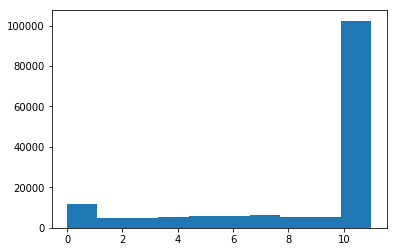

In [89]:
plt.hist(classes,bins=10)

### submission

In [90]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [91]:
with open('subm/{}.csv'.format(exp_name), 'w') as fout: #_blend_conv1dlstm_and_aebased_conv2d_finetuned
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [92]:
from IPython.lib.display import FileLink

FileLink('subm/{}.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/timeconv5_freqconv10_wlstm128_pseudowval.csv